
## Crypto


In [1]:

## !pip install pycryptodome


In [23]:


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from Crypto.Util.number import getPrime, inverse, GCD
import math

torch.manual_seed(42)

device = torch.device("cpu")



In [24]:

# ======= Real RSA Generator =======
def generate_valid_rsa_sample(bits=8):
    """Return (x=[p,q,e], y=[n,phi,d]) as float tensors."""
    while True:
        p = getPrime(bits)
        q = getPrime(bits)
        phi = (p - 1) * (q - 1)
        # find small odd e that is coprime to phi
        for e in range(3, 1000, 2):
            if GCD(e, phi) == 1:
                try:
                    d = inverse(e, phi)
                    x = torch.tensor([p, q, e], dtype=torch.float32)
                    y = torch.tensor([p * q, phi, d], dtype=torch.float32)
                    return x, y
              
                except:
                    continue
                    
                    

In [25]:

def gen_data(N=1000, bits=8):
    xs, ys = [], []
    for _ in range(N):
        x, y = generate_valid_rsa_sample(bits)
        xs.append(x)
        ys.append(y)
    return torch.stack(xs).to(device), torch.stack(ys).to(device)


In [26]:


# ======= Forward Neural Model =======
class ForwardModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )
    def forward(self, x):
        return self.net(x)
    



In [27]:

# ======= Hamming Weight Score =======
def hamming_weight(d):
    """
    d: [batch] float/int tensor
    returns: normalized Hamming weight in [0,1] for 32 bits
    """
    d_int = d.long().unsqueeze(1)  # Ensure shape [batch, 1]
    ## bits  = d_int.bitwise_and(1 << torch.arange(32)).bool().float()
    bits = d_int.bitwise_and(1 << torch.arange(32, device=d.device)).bool().float()  # [B,32]
    return bits.sum(dim=1) / 32.0  # Normalized



In [28]:



# ======= Train Forward Model =======
def train_forward_model(x, y, epochs=300, lr=1e-3):
    model = ForwardModel().to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for epoch in range(epochs):
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
    return model


In [29]:


# ======= Constraint-Based Optimizer =======
def optimize_with_constraints(forward_model, y_target, score_target, steps=400, lr=0.01):
    """
    Optimize latent z so x = sigmoid(z)*300 produces y close to y_target
    and hamming_weight(d) close to score_target.
    Returns final x, y and the sampled history (every 20 steps).
    """
    z = torch.randn((1, 3), device=device, requires_grad=True)
    opt = optim.Adam([z], lr=lr)
    history = []

    for step in range(steps):
        x = torch.sigmoid(z) * 300.0                    # [1,3] ~ [p,q,e] range
        y_pred = forward_model(x)                       # [1,3] ~ [n,phi,d]
        d_pred = y_pred[:, 2]
        score = hamming_weight(d_pred)                  # [1]

        loss = (
            nn.functional.mse_loss(y_pred, y_target)
            + 10.0 * nn.functional.mse_loss(score, score_target)
        )

        opt.zero_grad()
        loss.backward()
        opt.step()

        if step % 20 == 0:
            history.append(
                (  x.detach().clone(), y_pred.detach().clone(), score.detach().item()  )
            )

    return x.detach(), y_pred.detach(), history


In [30]:

# ======= Main Experiment =======
print("Generating data and training model...")
x_train, y_train = gen_data(1000)   # real RSA tuples

print( x_train.shape )
print( y_train.shape )



Generating data and training model...
torch.Size([1000, 3])
torch.Size([1000, 3])


In [31]:


forward_model = train_forward_model(x_train, y_train, epochs=300)




In [32]:


optimized_inputs = []
optimized_outputs = []
optimized_scores = []




In [33]:



print("Running constraint optimization for different scores...")
for i in range(10):
    y_target     = y_train[i:i+1]               # pick a seed output
    score_target = torch.tensor([i / 10.0], dtype=torch.float32, device=device)
    
    x_opt, y_opt, hist = optimize_with_constraints(forward_model, y_target, score_target, steps=400)
    
    optimized_inputs.append(x_opt.squeeze(0).cpu().numpy())
    optimized_outputs.append(y_opt.squeeze(0).cpu().numpy())
    optimized_scores.append(score_target.item())
    


Running constraint optimization for different scores...


In [34]:


optimized_inputs  = np.array( optimized_inputs  )    # [10,3]
optimized_outputs = np.array( optimized_outputs )    # [10,3]
optimized_scores  = np.array( optimized_scores  )    # [10]


In [35]:


# ======= 2D Visualization (t-SNE of outputs [n,phi,d]) =======
output_array = optimized_outputs
tsne = TSNE(n_components=2, perplexity=5, init="pca", random_state=42)
embeddings = tsne.fit_transform(output_array)




/home/maquina1/anaconda3/envs/py37_Constraints/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/maquina1/anaconda3/envs/py37_Constraints/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


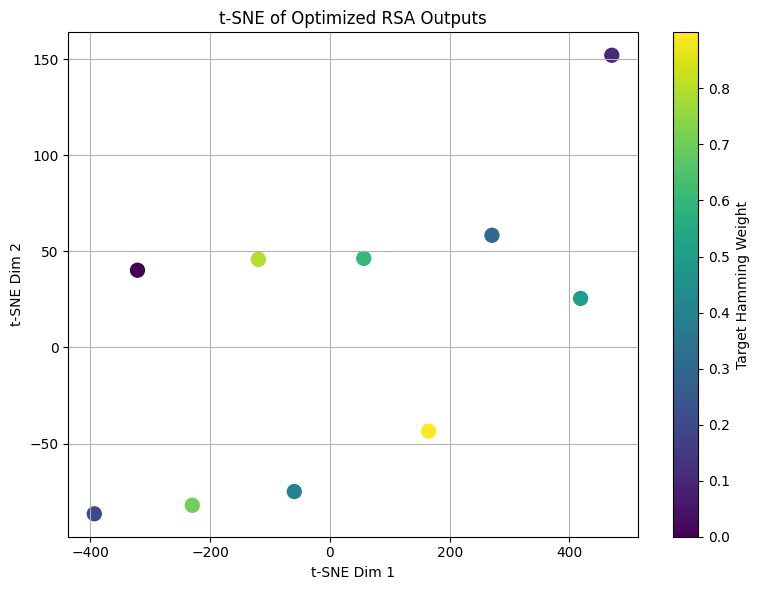

In [36]:

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=optimized_scores, cmap="viridis", s=100)
plt.colorbar(scatter, label="Target Hamming Weight")
plt.title("t-SNE of Optimized RSA Outputs")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()






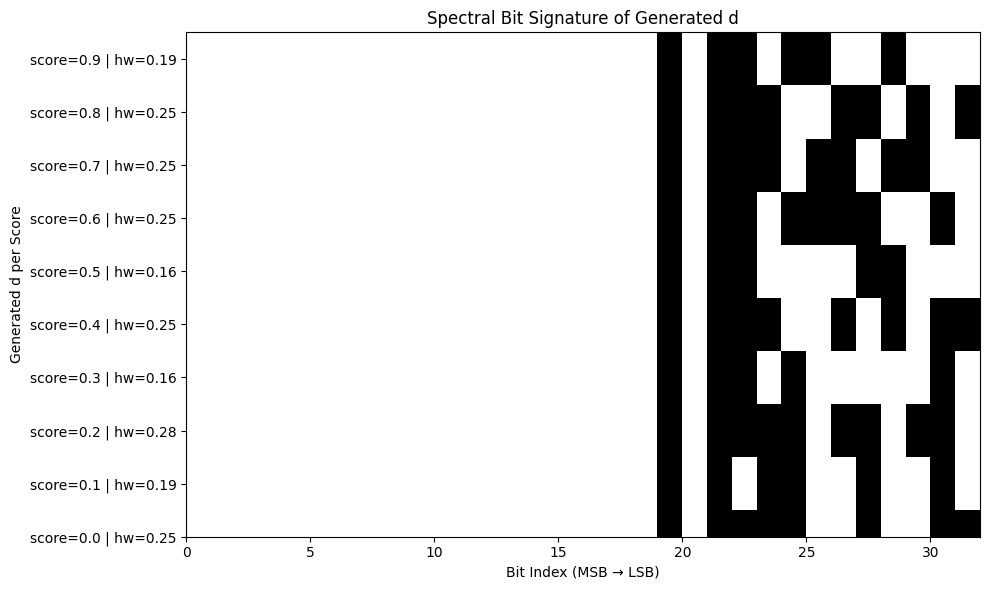

In [37]:



# ======= Spectrogram-style Visualization of d Bits (with actual HW labels) =======
plt.figure(figsize=(10, 6))
actual_hw = []
for i, y in enumerate(optimized_outputs):
    d_val = int(y[2])
    bits = [(d_val >> b) & 1 for b in range(31, -1, -1)]  # MSB→LSB
    actual_hw.append(sum(bits)/32.0)
    plt.imshow([bits], aspect='auto', cmap='Greys', extent=[0, 32, i, i+1])

yticks = [f"score={s:.1f} | hw={h:.2f}" for s, h in zip(optimized_scores, actual_hw)]
plt.yticks(np.arange(10) + 0.5, yticks)
plt.xlabel("Bit Index (MSB → LSB)")
plt.ylabel("Generated d per Score")
plt.title("Spectral Bit Signature of Generated d")
plt.tight_layout()
plt.show()




In [38]:


# ======================
# Build constrained dataset + train inverse model
# ======================

@torch.no_grad()
def build_constrained_dataset(forward_model, y_pool, scores, runs_per_score=20, steps=300):
    """
    Use the same constraint optimizer to create many (x̂, ŷ, score) triples.
    Returns tensors X:[N,3], Y:[N,3], S:[N,1]
    """
    X_list, Y_list, S_list = [], [], []
    idx = 0
    for s in scores:
        score_target = torch.tensor([s], dtype=torch.float32, device=device)
        for _ in range(runs_per_score):
            y_target = y_pool[idx % len(y_pool): idx % len(y_pool) + 1]
            idx += 1
            x_opt, y_opt, _ = optimize_with_constraints(forward_model, y_target, score_target, steps=steps)
            X_list.append(x_opt.squeeze(0))
            Y_list.append(y_opt.squeeze(0))
            S_list.append(score_target)
    X = torch.stack(X_list).to(device)
    Y = torch.stack(Y_list).to(device)
    S = torch.stack(S_list).view(-1, 1).to(device)
    return X, Y, S



In [39]:


class InverseModel(nn.Module):
    """Score-conditioned inverse: [ŷ(3), score(1)] -> x̂(3)"""
    def __init__(self, in_dim=4, out_dim=3, width=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, out_dim),
        )
    def forward(self, feats):
        return self.net(feats)


In [40]:

def train_inverse(Y, S, X, epochs=250, batch_size=256, lr=1e-3):
    feats = torch.cat([Y, S], dim=1)   # [N,4]
    ds = torch.utils.data.TensorDataset(feats, X)
    dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
    model = InverseModel().to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for _ in range(epochs):
        for f_b, x_b in dl:
            pred = model(f_b)
            loss = loss_fn(pred, x_b)
            opt.zero_grad(); loss.backward(); opt.step()
    return model


In [41]:


@torch.no_grad()
def eval_inverse(inv_model, Yt, St, Xt):
    feats = torch.cat([Yt, St], dim=1)
    pred = inv_model(feats)
    mae = (pred - Xt).abs().mean(0)
    return pred, mae


In [42]:


print("Building constrained dataset for inverse training...")
scores = np.linspace(0.0, 0.9, 10).tolist()
X_gen, Y_gen, S_gen = build_constrained_dataset(
    forward_model,
    y_pool=y_train,          # reuse the RSA outputs as seeds
    scores=scores,
    runs_per_score=30,       # 10*30 = 300 samples; increase for better inverse
    steps=250
)


Building constrained dataset for inverse training...


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:

# Train/test split
N = X_gen.size(0)
perm = torch.randperm(N)
train_idx, test_idx = perm[: int(0.8*N)], perm[int(0.8*N):]
X_tr, Y_tr, S_tr = X_gen[train_idx], Y_gen[train_idx], S_gen[train_idx]
X_te, Y_te, S_te = X_gen[test_idx],  Y_gen[test_idx],  S_gen[test_idx]


In [ ]:


print("Training inverse model ([ŷ,score] → x̂)...")
inverse_model = train_inverse(Y_tr, S_tr, X_tr, epochs=250, batch_size=256, lr=1e-3)


In [ ]:

with torch.no_grad():
    pred_x, mae = eval_inverse(inverse_model, Y_te, S_te, X_te)

print("Inverse MAE per field [p,q,e]:", [round(v,3) for v in mae.cpu().tolist()])



In [ ]:

# ======= Fast inference + optional refinement =======
@torch.no_grad()
def fast_inverse_predict(inv_model, y_desired, score_desired):
    if score_desired.dim() == 0:
        score_desired = score_desired.view(1,1)
    feats = torch.cat([y_desired.to(device), score_desired.to(device)], dim=1)
    return inv_model(feats)  # [1,3]


In [ ]:


def refine_with_optimizer(forward_model, y_target, score_target, x_init, steps=75, lr=0.01):
    """
    Start from x_init (from inverse) and do a short constraint optimization to
    tighten constraint satisfaction.
    """
    # map x_init in (0,300) back to latent z using logit, clamp to avoid inf
    z = torch.logit((x_init / 300.0).clamp(1e-4, 1-1e-4)).clone().detach().requires_grad_(True)
    opt = optim.Adam([z], lr=lr)
    for _ in range(steps):
        x = torch.sigmoid(z) * 300.0
        y_pred = forward_model(x)
        d_pred = y_pred[:, 2]
        score = hamming_weight(d_pred)
        loss = nn.functional.mse_loss(y_pred, y_target) + 10.0*nn.functional.mse_loss(score, score_target)
        opt.zero_grad(); loss.backward(); opt.step()
    return x.detach(), y_pred.detach(), score.detach()


In [ ]:

# Demo on one test case
y_star = Y_te[:1]
s_star = torch.tensor([0.6], dtype=torch.float32, device=device)
x_guess = fast_inverse_predict(inverse_model, y_star, s_star)
x_refined, y_refined, s_refined = refine_with_optimizer(forward_model, y_star, s_star, x_guess, steps=60, lr=0.01)

print("\n--- Inference demo ---")
print("Desired score:", s_star.item())
print("Inverse guess x:", x_guess.cpu().numpy())
print("Refined x     :", x_refined.cpu().numpy())
print("Refined y     :", y_refined.cpu().numpy())
print("Refined score :", s_refined.item())
